In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
import seaborn as sns
from pycaret.regression import *
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('train.tsv', sep='\t')
test_data = pd.read_csv('test.tsv', sep='\t')
dataset

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,39.4,4,85.0,70,2070,18.6,78,3,datsun b210 gx
1,3,18.0,6,171.0,97,2984,14.5,75,1,ford pinto
2,9,32.7,6,168.0,132,2910,11.4,80,3,datsun 280-zx
3,11,38.1,4,89.0,60,1968,18.8,80,3,toyota corolla tercel
4,13,28.0,4,98.0,80,2164,15.0,72,1,dodge colt (sw)
...,...,...,...,...,...,...,...,...,...,...
194,384,27.0,4,97.0,88,2130,14.5,70,3,datsun pl510
195,385,26.0,4,79.0,67,1963,15.5,74,2,volkswagen dasher
196,387,29.0,4,135.0,84,2525,16.0,82,1,dodge aries se
197,395,31.3,4,120.0,75,2542,17.5,80,3,mazda 626


外れ値探し

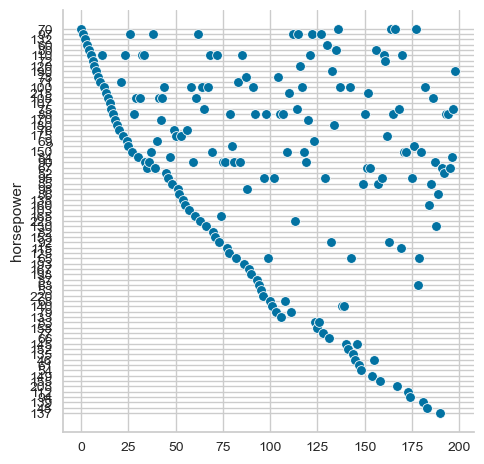

In [3]:
#散布図のプロット（外れ値探し）
sns.relplot(data=dataset['horsepower'])

In [4]:
#ユニークな要素をカウント
dataset['cylinders'].value_counts()

cylinders
4    98
8    55
6    42
5     2
3     2
Name: count, dtype: int64

In [5]:
#データフレーム全体で"?"の要素をNaNに変換
dataset = dataset.mask(dataset  == "?")
test_data = test_data.mask(test_data  == "?")
#各行でNaNをカウント
dataset.isnull().sum()

Unnamed: 0      0
mpg             0
cylinders       0
displacement    0
horsepower      3
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [6]:
#"horsepower"列でNaNがある行を抽出
dataset[dataset['horsepower'].isna()]

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
25,50,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe
80,166,34.5,4,100.0,NaN,2320,15.8,81,2,renault 18i
176,351,23.6,4,140.0,NaN,2905,14.3,80,1,ford mustang cobra


In [7]:
test_data[test_data['horsepower'].isna()]

,Unnamed: 0,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
50,101,4,151.0,NaN,3035,20.5,82,1,amc concord dl
85,164,6,200.0,NaN,2875,17.0,74,1,ford maverick
181,363,4,98.0,NaN,2046,19.0,71,1,ford pinto


In [8]:
#文字列をspritした頭を抽出
dataset['bland'] = dataset['car name'].apply(lambda x: x.split(' ')[0])
test_data['bland'] = test_data['car name'].apply(lambda x: x.split(' ')[0])
dataset

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland
0,0,39.4,4,85.0,70,2070,18.6,78,3,datsun b210 gx,datsun
1,3,18.0,6,171.0,97,2984,14.5,75,1,ford pinto,ford
2,9,32.7,6,168.0,132,2910,11.4,80,3,datsun 280-zx,datsun
3,11,38.1,4,89.0,60,1968,18.8,80,3,toyota corolla tercel,toyota
4,13,28.0,4,98.0,80,2164,15.0,72,1,dodge colt (sw),dodge
...,...,...,...,...,...,...,...,...,...,...,...
194,384,27.0,4,97.0,88,2130,14.5,70,3,datsun pl510,datsun
195,385,26.0,4,79.0,67,1963,15.5,74,2,volkswagen dasher,volkswagen
196,387,29.0,4,135.0,84,2525,16.0,82,1,dodge aries se,dodge
197,395,31.3,4,120.0,75,2542,17.5,80,3,mazda 626,mazda


In [9]:
hp_impute =dataset[~dataset['horsepower'].isna()]
hp_impute['horsepower'] = hp_impute['horsepower'].astype(int)
df_corr = hp_impute.drop(["car name","bland","Unnamed: 0"],axis=1).corr()
df_corr["horsepower"]
cylinders_gr_mean = hp_impute.groupby(['cylinders'])['horsepower'].mean()
cylinders_gr_mean

cylinders
3     98.500000
4     79.115789
5     90.000000
6    100.380952
8    162.036364
Name: horsepower, dtype: float64

In [10]:
test_hp_impute =test_data[~test_data['horsepower'].isna()]
test_hp_impute['horsepower'] = test_hp_impute['horsepower'].astype(int)
test_cylinders_gr_mean = test_hp_impute.groupby(['cylinders'])['horsepower'].mean()
test_cylinders_gr_mean

cylinders
3    100.000000
4     77.519231
5     67.000000
6    102.658537
8    154.020833
Name: horsepower, dtype: float64

In [11]:
"""
groups = hp_impute.groupby('cylinders')
fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(5, len(groups)*5))

# 各グループに対してサブプロットを作成
for (name, group), ax in zip(groups, axes):
    ax.scatter(group['Unnamed: 0'], group['horsepower'])
    ax.set_title(f'Category {name}')
    ax.set_xlabel('X Value')
    ax.set_ylabel('Y Value')

plt.tight_layout()
plt.show()
"""

"\ngroups = hp_impute.groupby('cylinders')\nfig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(5, len(groups)*5))\n\n# 各グループに対してサブプロットを作成\nfor (name, group), ax in zip(groups, axes):\n    ax.scatter(group['Unnamed: 0'], group['horsepower'])\n    ax.set_title(f'Category {name}')\n    ax.set_xlabel('X Value')\n    ax.set_ylabel('Y Value')\n\nplt.tight_layout()\nplt.show()\n"

In [12]:
merge_dataset = pd.merge(dataset, cylinders_gr_mean, on='cylinders').sort_values(by='Unnamed: 0').reset_index(drop=True)
merge_dataset = merge_dataset.rename(columns={'horsepower_x': 'horsepower', 'horsepower_y': 'horsepower_mean'})
merge_dataset
merge_dataset['horsepower'] = merge_dataset['horsepower'].fillna(merge_dataset['horsepower_mean'])  
merge_dataset.loc[[25,80,176]]#.isna().sum()

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland,horsepower_mean
25,50,40.9,4,85.0,79.115789,1835,17.3,80,2,renault lecar deluxe,renault,79.115789
80,166,34.5,4,100.0,79.115789,2320,15.8,81,2,renault 18i,renault,79.115789
176,351,23.6,4,140.0,79.115789,2905,14.3,80,1,ford mustang cobra,ford,79.115789


In [13]:
merge_test_data = pd.merge(test_data, test_cylinders_gr_mean, on='cylinders').sort_values(by='Unnamed: 0').reset_index(drop=True)
merge_test_data = merge_test_data.rename(columns={'horsepower_x': 'horsepower', 'horsepower_y': 'horsepower_mean'})
#merge_test_data
merge_test_data['horsepower'] = merge_test_data['horsepower'].fillna(merge_test_data['horsepower_mean'])  
merge_test_data.loc[[50,85,181]]#.isna().sum()

,Unnamed: 0,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,bland,horsepower_mean
50,101,4,151.0,77.519231,3035,20.5,82,1,amc concord dl,amc,77.519231
85,164,6,200.0,102.658537,2875,17.0,74,1,ford maverick,ford,102.658537
181,363,4,98.0,77.519231,2046,19.0,71,1,ford pinto,ford,77.519231


In [14]:
train=merge_dataset.drop(["Unnamed: 0","car name",'horsepower_mean'],axis=1)
test=merge_test_data.drop(["Unnamed: 0","car name",'horsepower_mean'],axis=1)
test

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,bland
0,8,350.0,180,4499,12.5,73,1,oldsmobile
1,4,156.0,105,2745,16.7,78,1,plymouth
2,6,156.0,108,2930,15.5,76,3,toyota
3,4,108.0,70,2245,16.9,82,3,toyota
4,4,105.0,63,2125,14.7,82,1,plymouth
...,...,...,...,...,...,...,...,...
194,8,305.0,140,4215,13.0,76,1,chevrolet
195,8,318.0,150,4237,14.5,73,1,plymouth
196,8,350.0,145,4055,12.0,76,1,chevy
197,3,80.0,110,2720,13.5,77,3,mazda


In [15]:
reg = setup(data = train,
            target = 'mpg',
            session_id=999,
            data_split_shuffle = True,
            categorical_features = ['bland'],
            fold_strategy = 'kfold',
            use_gpu = False,
            fold=5,
            n_jobs = -1)

,Description,Value
0,Session id,999
1,Target,mpg
2,Target type,Regression
3,Original data shape,"(199, 9)"
4,Transformed data shape,"(199, 9)"
5,Transformed train set shape,"(139, 9)"
6,Transformed test set shape,"(60, 9)"
7,Numeric features,6
8,Categorical features,1
9,Preprocess,True


In [16]:
best = compare_models(sort = 'MAE') #モデル比較

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.8369,6.4740,2.4593,0.8611,0.1015,0.0831,0.0920
rf,Random Forest Regressor,1.9365,7.3718,2.5961,0.8450,0.1062,0.0874,0.1200
lightgbm,Light Gradient Boosting Machine,1.9932,6.4418,2.5052,0.8667,0.1051,0.0904,0.1080
ada,AdaBoost Regressor,2.0040,7.4798,2.6519,0.8463,0.1089,0.0911,0.0800
gbr,Gradient Boosting Regressor,2.0077,7.0109,2.5559,0.8546,0.1090,0.0929,0.0660
dt,Decision Tree Regressor,2.8012,14.6928,3.7011,0.7118,0.1584,0.1309,0.0440
knn,K Neighbors Regressor,3.1612,16.9362,4.0745,0.6510,0.1603,0.1367,0.0400
dummy,Dummy Regressor,5.9700,52.1729,7.1851,-0.0383,0.3064,0.2934,0.0320


In [17]:
model = create_model("et") #予測モデルに Extra Trees Regressor を選択
tuned_model = tune_model(model, optimize='MAE') #MAEで最適化

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0836,8.7825,2.9635,0.8667,0.1295,0.0995
1,0.8965,1.4839,1.2182,0.9770,0.0548,0.0441
2,2.1715,8.9542,2.9924,0.7986,0.1098,0.0885
3,2.3026,7.2010,2.6835,0.8125,0.1049,0.0963
4,1.7304,5.9484,2.4389,0.8507,0.1084,0.0873
Mean,1.8369,6.4740,2.4593,0.8611,0.1015,0.0831
Std,0.5070,2.7271,0.6526,0.0630,0.0249,0.0201


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3439,11.5285,3.3954,0.8250,0.1469,0.1147
1,0.9514,1.6642,1.2900,0.9743,0.0568,0.0462
2,2.4724,12.0741,3.4748,0.7284,0.1245,0.0962
3,2.0622,6.6039,2.5698,0.8281,0.1016,0.0861
4,1.7745,5.9416,2.4375,0.8508,0.1111,0.0928
Mean,1.9209,7.5625,2.6335,0.8413,0.1082,0.0872
Std,0.5412,3.8580,0.7919,0.0787,0.0299,0.0226


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [20]:
evaluate_model(tuned_model) #パラメータ確認

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [21]:
final_model = finalize_model(tuned_model) #モデルの確定

In [23]:
result = predict_model(final_model, data = test) #テストデータで予測

In [29]:
result = result.rename(columns={'prediction_label':'mpg'})
result

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,bland,mpg
0,8,350.0,180,4499,12.500000,73,1,oldsmobile,12.830
1,4,156.0,105,2745,16.700001,78,1,plymouth,24.448
2,6,156.0,108,2930,15.500000,76,3,toyota,21.539
3,4,108.0,70,2245,16.900000,82,3,toyota,33.906
4,4,105.0,63,2125,14.700000,82,1,plymouth,35.754
...,...,...,...,...,...,...,...,...,...
194,8,305.0,140,4215,13.000000,76,1,chevrolet,14.495
195,8,318.0,150,4237,14.500000,73,1,plymouth,14.380
196,8,350.0,145,4055,12.000000,76,1,chevy,15.095
197,3,80.0,110,2720,13.500000,77,3,mazda,22.360


In [32]:
sub=pd.read_csv('sample_submit.csv',header=None,names=['id','mpg'])
sub

,id,mpg
0,1,40.9
1,2,28.8
2,4,11.0
3,5,19.4
4,6,14.0
...,...,...
194,391,20.5
195,392,16.0
196,393,18.2
197,394,37.2


In [33]:
sub['mpg'] = result['mpg']
sub['mpg'] = sub['mpg'].astype(int) #intにしていることに注意
sub

,id,mpg
0,1,12
1,2,24
2,4,21
3,5,33
4,6,35
...,...,...
194,391,14
195,392,14
196,393,15
197,394,22


In [34]:
sub.to_csv('sub.csv',header=False,index=False)